In [88]:
from zipfile import ZipFile
from utils.download_sample import download_from_dropbox
from utils.coordinate_utils import extract_coordinates, normalize_coords_to_pixel
from utils.imutils import *
from utils.shapely_and_napari_utils import *
from pathlib import Path
import napari
from napari.utils import nbscreenshot
import time
from shapely.geometry import GeometryCollection
from shapely.geometry import Point
from skimage.transform import AffineTransform
import dask.array as da
from scipy.ndimage import affine_transform

In [2]:
%gui qt

In [3]:
time.sleep(1)

In [4]:
if not Path("Stiching_Example_Dataset").exists():
    # Download and extract sample data
    example_dataset="https://www.dropbox.com/s/rhggl54sbpx9llj/Stiching_Example_Dataset.zip?dl=0"
    print("Downloading sample file from dropbox")
    download_from_dropbox(example_dataset, "_sample.zip")
    print("Extracting sample file")
    ZipFile("_sample.zip").extractall()

Extracting sample file


In [5]:
coords = extract_coordinates("Stiching_Example_Dataset/out.txt")
coords

,name,X,Y,Z,um/px
0,1_0000,3582.7,4164.4,1686.65,0.64
1,1_0001,-12396.6,11719.3,1686.63,0.64
2,1_0002,-13583.0,11726.0,1686.63,0.64
3,1_0003,-14769.3,11732.8,1686.63,0.64
4,1_0004,-15955.6,11739.5,1686.63,0.64
...,...,...,...,...,...
67,1_0067,-16003.1,3370.3,1686.63,0.64
68,1_0068,-14816.8,3363.5,1686.63,0.64
69,1_0069,-13630.5,3356.8,1686.63,0.64
70,1_0070,-12444.2,3350.1,1686.63,0.64


In [6]:
files = sorted(list(Path("Stiching_Example_Dataset").glob("*.jpg")))
files

[PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0000.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0001.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0002.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0003.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0004.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0005.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0006.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0007.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0008.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0009.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0010.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0011.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0012.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0013.jpg'),
 PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0014.jpg'),
 PosixPath('Stiching_Exam

In [7]:
normalized_coords=normalize_coords_to_pixel(coords).to_numpy()

In [8]:
v = napari.Viewer()

2021-06-24 10:36:31,586 [INFO] WRITING LOG OUTPUT TO /home/hilsenst/.cellpose/run.log


In [9]:
# skip first image as it is an outlier (stage position wise)
mosaic_layers = []
for file, coord in zip(files[1:], normalized_coords[1:]):
    im = load_image(file)
    im = transpose(select_channel(crop_black_border(im),0))
    layer = v.add_image(im, translate=coord, name=file.stem)
    mosaic_layers.append(layer)

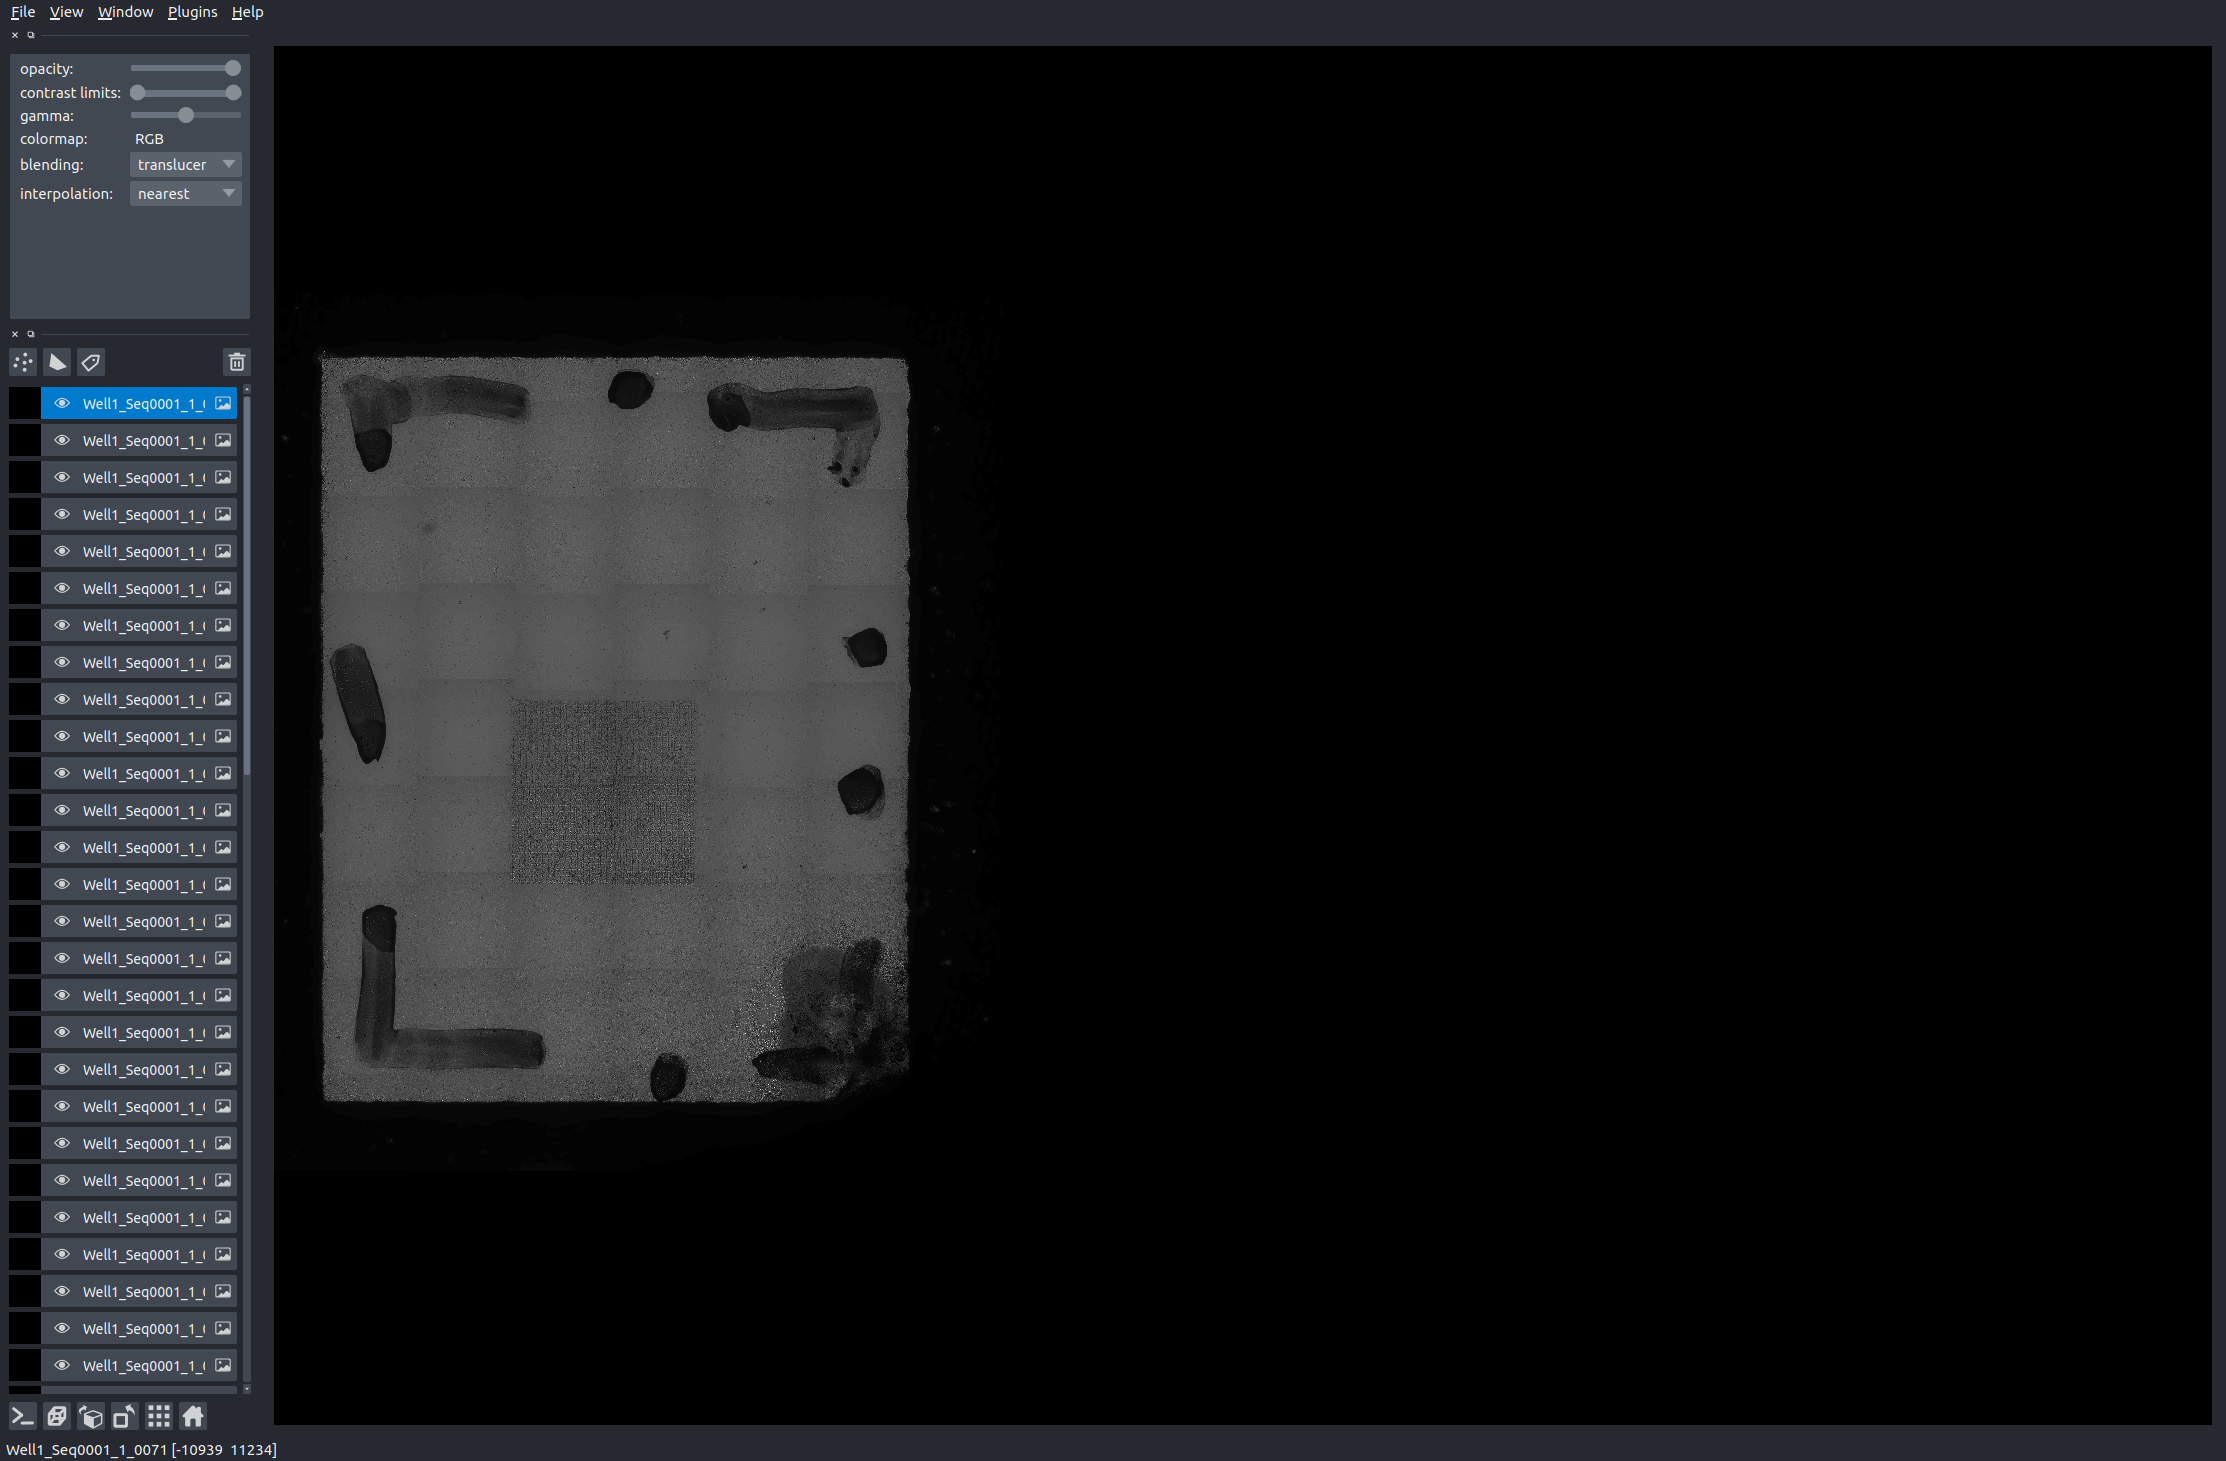

In [10]:
# taken after manually zooming out
nbscreenshot(v)

In [12]:
# check whether this still works in more recent versions of napari
# Marvin made some comments this may not be the case
for layer in mosaic_layers:
    print(layer.affine.affine_matrix)

[[ 1.00000000e+00  0.00000000e+00 -1.93696875e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83114062e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -2.12234375e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83218750e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -2.30770312e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83325000e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -2.49306250e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83429688e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -2.67842188e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83535938e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -2.86378125e+04]
 [ 0.00000000e+00  1.00000000e+00  1.83640625e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -3.04914062e+04]
 [ 0.00000000e+00  1.0000

In [13]:
for layer in mosaic_layers:
    print(layer.data.shape)
    print(get_image_layer_rect(layer))

(2044, 2048, 1)
[[-19369.6875   18311.40625]
 [-17325.6875   18311.40625]
 [-17325.6875   20359.40625]
 [-19369.6875   20359.40625]]
(2044, 2048, 1)
[[-21223.4375  18321.875 ]
 [-19179.4375  18321.875 ]
 [-19179.4375  20369.875 ]
 [-21223.4375  20369.875 ]]
(2044, 2048, 1)
[[-23077.03125  18332.5    ]
 [-21033.03125  18332.5    ]
 [-21033.03125  20380.5    ]
 [-23077.03125  20380.5    ]]
(2044, 2048, 1)
[[-24930.625    18342.96875]
 [-22886.625    18342.96875]
 [-22886.625    20390.96875]
 [-24930.625    20390.96875]]
(2044, 2048, 1)
[[-26784.21875  18353.59375]
 [-24740.21875  18353.59375]
 [-24740.21875  20401.59375]
 [-26784.21875  20401.59375]]
(2044, 2048, 1)
[[-28637.8125  18364.0625]
 [-26593.8125  18364.0625]
 [-26593.8125  20412.0625]
 [-28637.8125  20412.0625]]
(2044, 2048, 1)
[[-30491.40625  18374.53125]
 [-28447.40625  18374.53125]
 [-28447.40625  20422.53125]
 [-30491.40625  20422.53125]]
(2044, 2048, 1)
[[-32345.15625  18385.15625]
 [-30301.15625  18385.15625]
 [-30301.15

### Find oriented bounding boxes:

In [14]:
# find min/max x,y coordinates across all bounding boxes
oriented_bboxes=[]
for layer in mosaic_layers:
    oriented_bboxes.append(get_image_layer_rect(layer))

In [15]:
s=v.add_shapes(oriented_bboxes, name="bboxes of mosaic layers")

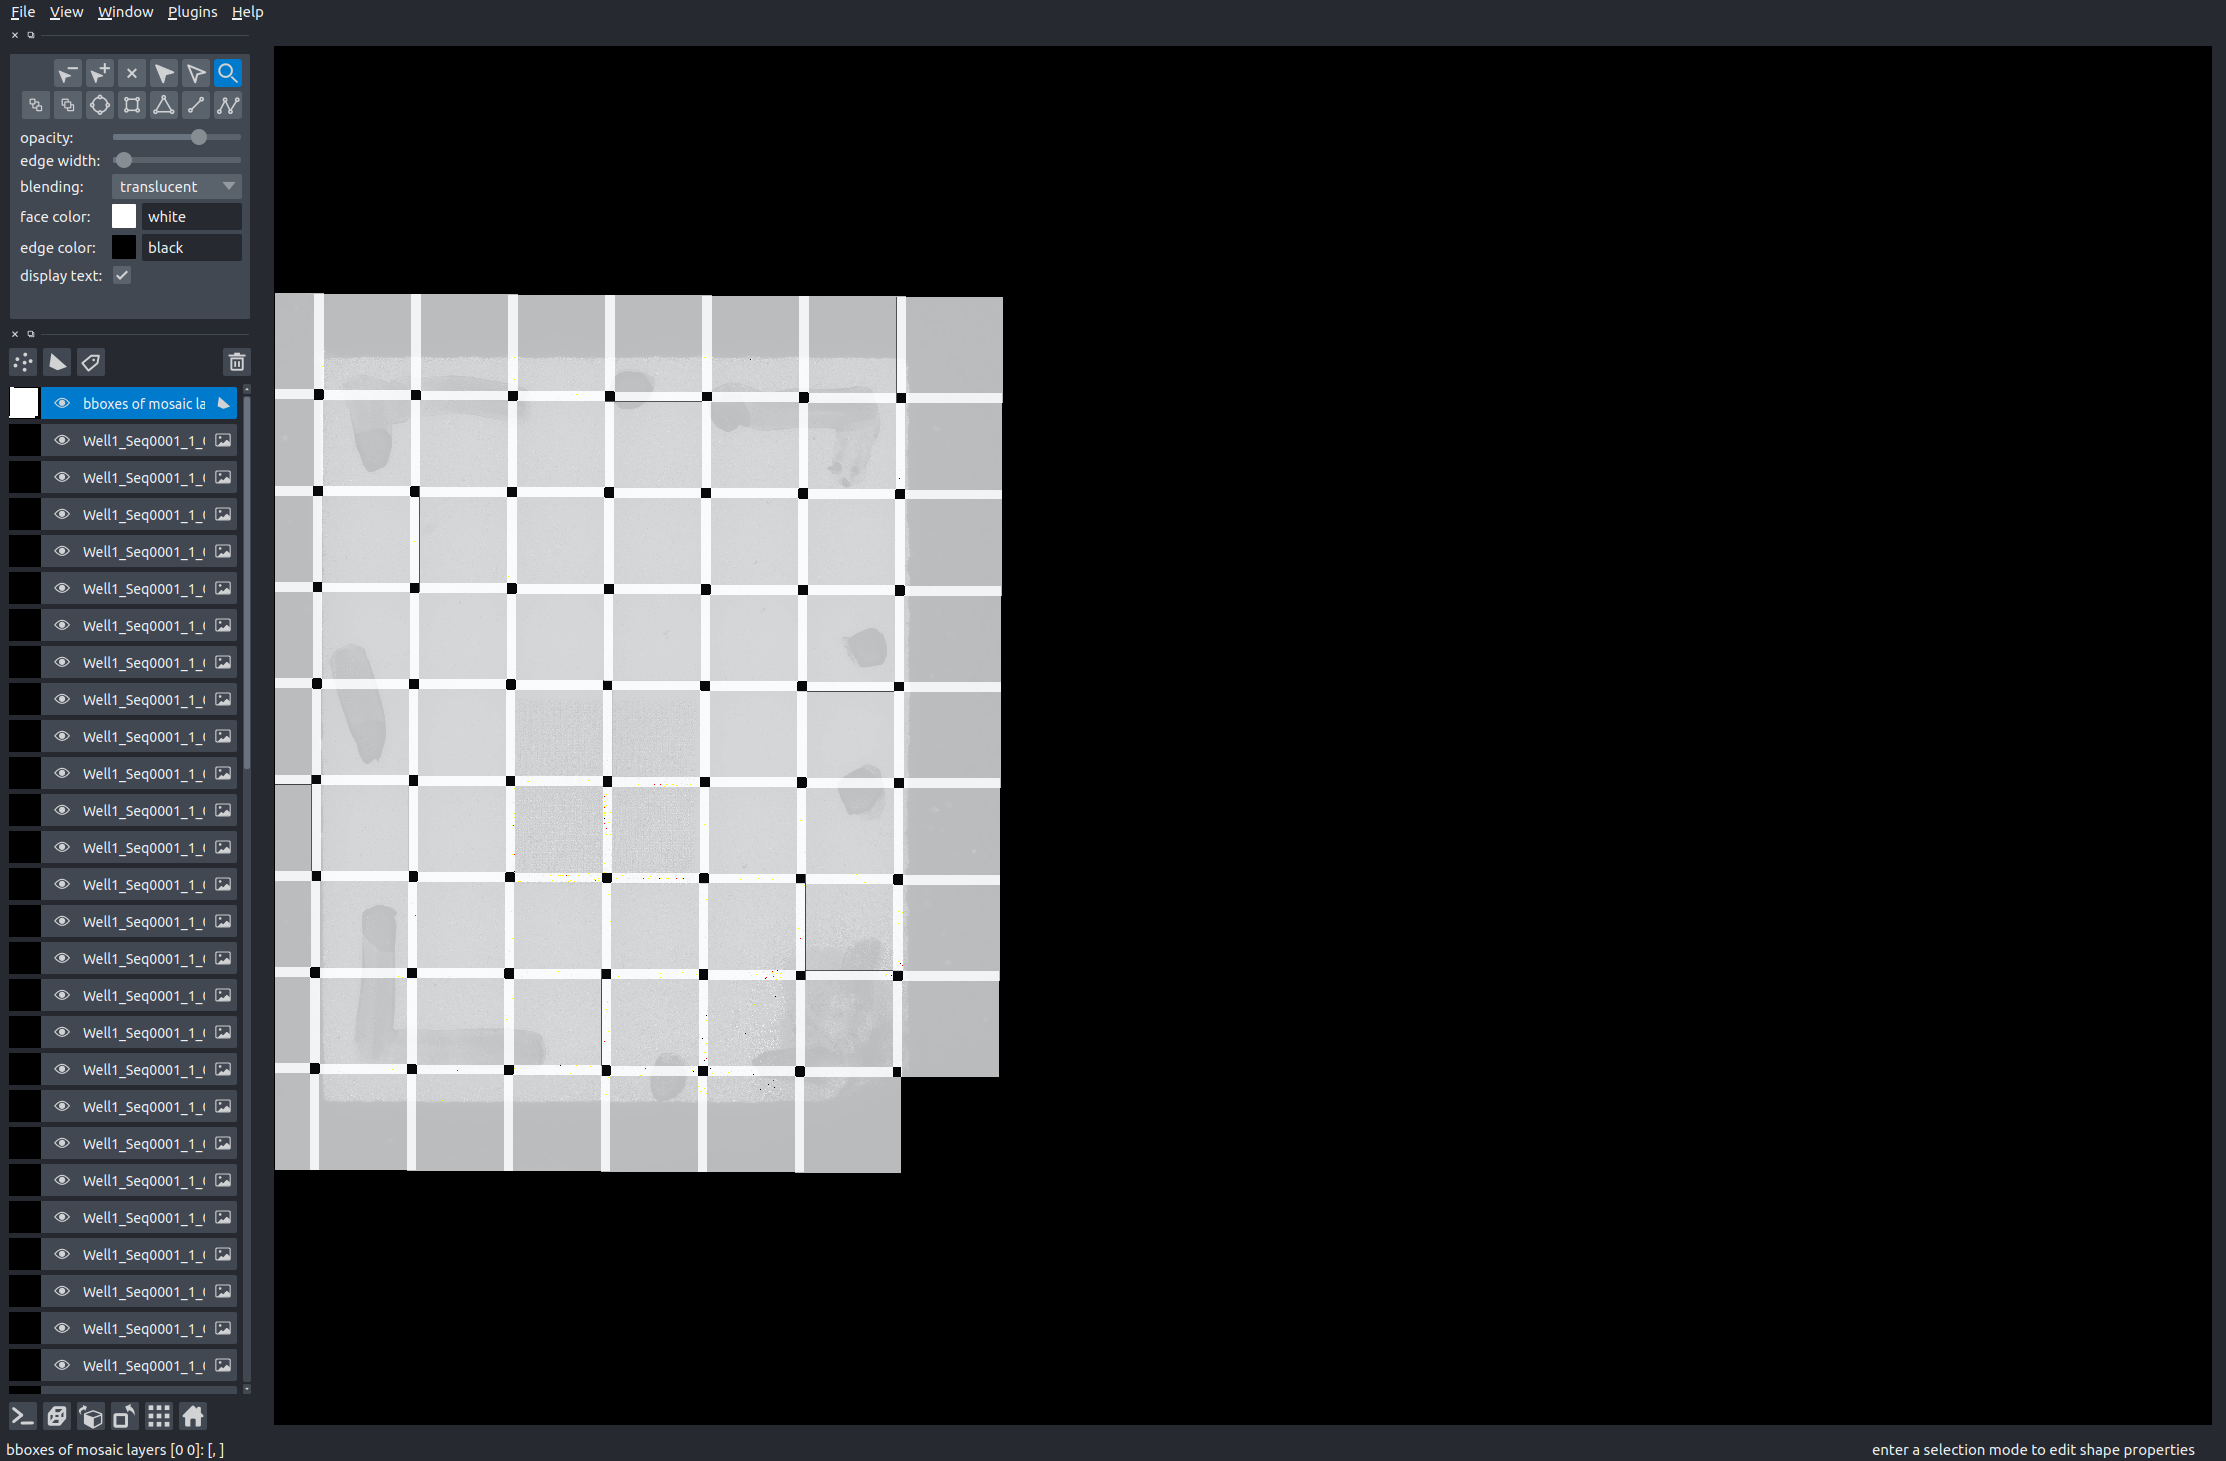

In [16]:
nbscreenshot(v)

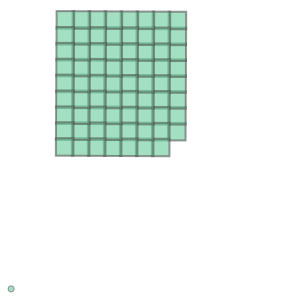

In [17]:
mosaic = napari_shape_layer_to_shapely(s)
origin = Point(0,0)
GeometryCollection((origin, mosaic))

### Move to origin
Find the translation that moves the stitched area to the origin and determine the size of the Zarr array we require.

In [25]:
all_bboxes = np.vstack(oriented_bboxes)

In [26]:
# minimum extents
all_min = all_bboxes.min(axis=0)
all_min

array([-32419.375  ,   5223.90625])

In [27]:
# maximum extents
all_max = all_bboxes.max(axis=0)
all_max

array([-15482.71875,  20433.15625])

In [28]:
# total extents shape
all_max - all_min

array([16936.65625, 15209.25   ])

In [69]:
stitched_shape=tuple(np.ceil(all_max-all_min).astype(np.int))
stitched_shape

(16937, 15210)

In [30]:
shift_to_origin = AffineTransform(translation=-all_min)
shift_to_origin.params

array([[ 1.00000000e+00, -0.00000000e+00,  3.24193750e+04],
       [ 0.00000000e+00,  1.00000000e+00, -5.22390625e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [31]:
# shift all layers of mosaic
for layer in mosaic_layers:
    layer.affine = layer.affine.affine_matrix @ shift_to_origin

In [32]:
# find min/max x,y coordinates across all bounding boxes
oriented_bboxes=[]
for layer in mosaic_layers:
    oriented_bboxes.append(get_image_layer_rect(layer))

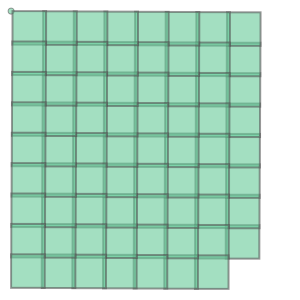

In [33]:
# find min/max x,y coordinates across all bounding boxes
oriented_bboxes=[]
for layer in mosaic_layers:
    oriented_bboxes.append(get_image_layer_rect(layer))
s_shifted = v.add_shapes(oriented_bboxes, name="bboxes after shift")
mosaic_shifted = napari_shape_layer_to_shapely(s_shifted)
origin = Point(0,0)
GeometryCollection((origin, mosaic_shifted))

## Create a dask array

In [55]:
chunk_size = (4096,4096)

In [56]:
#input_dtype = mosaic_layers[0].data.dtype
#target_array = da.zeros(stitched_shape, dtype=input_dtype, chunks=(4000, 4000))
#target_array.chunks
normalize_chunks((4096,4096),shape=tuple(stitched_shape))

((4096, 4096, 4096, 4096, 553), (4096, 4096, 4096, 2922))

In [70]:
# sanity check
computed_shape = np.array(list(map(sum, target_array.chunks)))
assert np.all(np.array(stitched_shape) == computed_shape)

In [71]:
def chunk_coordinates(shape: Tuple[int, int], chunk_size: Tuple[int,int], return_np_slice: bool=False):
    """  Iterator that returns the bounding coordinates
    for the individual chunks of a dask array of size
    shape with chunk size chunk_size.
    
    
    return_np_slice determines the output format. If True,
    a numpy slice object is returned for each chunk, that can be used 
    directly to slice a dask array to return the desired chunk region.
    If False, a Tuple of Tuples ((row_min, row_max+1),(col_min, col_max+1))
    is returned.
    """
    chunksy, chunksx = normalize_chunks(chunk_size, shape=shape)
    y=0
    for cy in chunksy:
        x =0 
        for cx in chunksx:
            if return_np_slice:
                yield np.s_[y:y+cy, x:x+cx]  
            else:
                yield((y,y+cy), (x,x+cx))
            x = x + cx
        y=y + cy

In [73]:
chunk_slices = list(chunk_coordinates(stitched_shape, chunk_size))
chunk_slices

[((0, 4096), (0, 4096)),
 ((0, 4096), (4096, 8192)),
 ((0, 4096), (8192, 12288)),
 ((0, 4096), (12288, 15210)),
 ((4096, 8192), (0, 4096)),
 ((4096, 8192), (4096, 8192)),
 ((4096, 8192), (8192, 12288)),
 ((4096, 8192), (12288, 15210)),
 ((8192, 12288), (0, 4096)),
 ((8192, 12288), (4096, 8192)),
 ((8192, 12288), (8192, 12288)),
 ((8192, 12288), (12288, 15210)),
 ((12288, 16384), (0, 4096)),
 ((12288, 16384), (4096, 8192)),
 ((12288, 16384), (8192, 12288)),
 ((12288, 16384), (12288, 15210)),
 ((16384, 16937), (0, 4096)),
 ((16384, 16937), (4096, 8192)),
 ((16384, 16937), (8192, 12288)),
 ((16384, 16937), (12288, 15210))]

In [74]:
def get_rect_from_chunk_slice(chunk_slice):
    ylim, xlim = chunk_slice
    miny, maxy = ylim[0], ylim[1]-1
    minx, maxx = xlim[0], xlim[1]-1
    return np.array([[miny, minx],[maxy, minx], [maxy, maxx], [miny,maxx]])

In [76]:
chunk_shapes = list(map(get_rect_from_chunk_slice, chunk_slices))

In [77]:
chunklayer = v.add_shapes(chunk_shapes, name="dask chunks", edge_color='red')

In [78]:
chunks_shapely = napari_shape_layer_to_shapely(chunklayer)

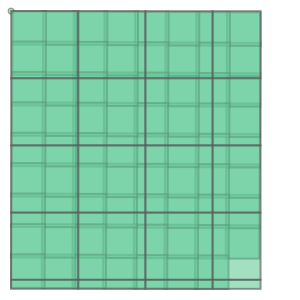

In [79]:
GeometryCollection([origin, mosaic_shifted, chunks_shapely])

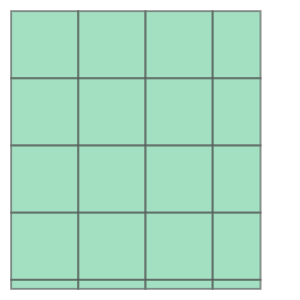

In [80]:
chunks_shapely

In [83]:
chunk_tiles = {}
tile_chunks = {}
for i, tile in enumerate(mosaic_shifted):
    print(f"Tile {i} intersects with:")
    for j, (chunk, chunk_slice) in enumerate(zip(chunks_shapely, chunk_slices)):
        anchor_point = (chunk_slice[0][0], chunk_slice[1][0])
        if tile.intersects(chunk):
            print(f"   chunk {j}")
            if i not in tile_chunks.keys():
                tile_chunks[i] = []
            tile_chunks[i].append(j)
            if anchor_point not in chunk_tiles.keys():
                chunk_tiles[anchor_point] = []
            chunk_tiles[anchor_point].append((mosaic_layers[i].name, mosaic_layers[i].affine.affine_matrix))
            print(f"intersection area {tile.intersection(chunk).area}")

Tile 0 intersects with:
   chunk 15
intersection area 4186112.0
Tile 1 intersects with:
   chunk 11
intersection area 2234496.0
   chunk 15
intersection area 1949568.0
Tile 2 intersects with:
   chunk 11
intersection area 4186112.0
Tile 3 intersects with:
   chunk 7
intersection area 1438208.0
   chunk 11
intersection area 2745856.0
Tile 4 intersects with:
   chunk 7
intersection area 4186112.0
Tile 5 intersects with:
   chunk 3
intersection area 641920.0
   chunk 7
intersection area 3542144.0
Tile 6 intersects with:
   chunk 3
intersection area 4186112.0
Tile 7 intersects with:
   chunk 3
intersection area 4185601.0
Tile 8 intersects with:
   chunk 2
intersection area 2031480.5
   chunk 3
intersection area 2152587.5
Tile 9 intersects with:
   chunk 2
intersection area 2053198.0
   chunk 3
intersection area 2130870.0
Tile 10 intersects with:
   chunk 2
intersection area 328913.310546875
   chunk 3
intersection area 334442.626953125
   chunk 6
intersection area 1744667.845703125
   chun

In [84]:
chunk_tiles

{(12288,
  12288): [('Well1_Seq0001_1_0001',
   array([[1.00000000e+00, 0.00000000e+00, 1.30496875e+04],
          [0.00000000e+00, 1.00000000e+00, 1.30875000e+04],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('Well1_Seq0001_1_0002',
   array([[1.00000000e+00, 0.00000000e+00, 1.11959375e+04],
          [0.00000000e+00, 1.00000000e+00, 1.30979688e+04],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('Well1_Seq0001_1_0015',
   array([[1.00000000e+00, 0.00000000e+00, 1.11853125e+04],
          [0.00000000e+00, 1.00000000e+00, 1.12298438e+04],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('Well1_Seq0001_1_0016',
   array([[1.00000000e+00, 0.00000000e+00, 1.30390625e+04],
          [0.00000000e+00, 1.00000000e+00, 1.12193750e+04],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('Well1_Seq0001_1_0017',
   array([[1.00000000e+00, 0.00000000e+00, 1.48926562e+04],
          [0.00000000e+00, 1.00000000e+00, 1.12087500e+04],
   

In [44]:
tile_chunks

{0: [15],
 1: [11, 15],
 2: [11],
 3: [7, 11],
 4: [7],
 5: [3, 7],
 6: [3],
 7: [3],
 8: [2, 3],
 9: [2, 3],
 10: [2, 3, 6, 7],
 11: [6, 7],
 12: [6, 7, 10, 11],
 13: [10, 11],
 14: [10, 11, 14, 15],
 15: [14, 15],
 16: [14, 15, 18, 19],
 17: [14, 18],
 18: [14],
 19: [10, 14],
 20: [10],
 21: [6, 10],
 22: [6],
 23: [2, 6],
 24: [2],
 25: [2],
 26: [1, 2],
 27: [1, 2],
 28: [1, 2, 5, 6],
 29: [5, 6],
 30: [5, 6, 9, 10],
 31: [9, 10],
 32: [9, 10, 13, 14],
 33: [13, 14],
 34: [13, 14, 17, 18],
 35: [13, 17],
 36: [13],
 37: [9, 13],
 38: [9],
 39: [5, 9],
 40: [5],
 41: [1, 5],
 42: [1],
 43: [1],
 44: [0, 1],
 45: [0, 1],
 46: [0, 1, 4, 5],
 47: [4, 5],
 48: [4, 5, 8, 9],
 49: [8, 9],
 50: [8, 9, 12, 13],
 51: [12, 13],
 52: [12, 13, 16, 17],
 53: [12, 16],
 54: [12],
 55: [8, 12],
 56: [8],
 57: [4, 8],
 58: [4],
 59: [0, 4],
 60: [0],
 61: [0, 1],
 62: [0],
 63: [0],
 64: [0, 4],
 65: [4],
 66: [4, 8],
 67: [8],
 68: [8, 12],
 69: [12],
 70: [12, 16]}

In [89]:
def fuse(input_tile_info, block_info=None):
    array_location = block_info[None]['array-location']
    anchor_point = (array_location[0][0], array_location[1][0])

    chunk_shape = block_info[None]['chunk-shape']
    tiles_info = input_tile_info[anchor_point]
    fused = np.zeros(chunk_shape, dtype=np.uint8)
    empty = True
    for tile_fname, tile_affine in tiles_info:
        im = load_image(Path("./Stiching_Example_Dataset/") / f"{tile_fname}.jpg")
        im = transpose(select_channel(crop_black_border(im),0))[...,0]
        shift = AffineTransform(translation=(-anchor_point[0], -anchor_point[1]))
        tile_shifted = affine_transform(im, matrix=np.linalg.inv(tile_affine@shift), output_shape=chunk_shape) #,offset=(anchor_point[0], anchor_point[1]))
        if np.any(tile_shifted):
            empty = False
        stack = np.stack([fused,tile_shifted])
        print(tile_fname, anchor_point, stack.shape, empty)
        fused = np.max(stack,axis=0)
    return fused

In [91]:
target_array = da.map_blocks(func=fuse,
                             chunks=normalize_chunks(chunk_size, stitched_shape), 
                             input_tile_info=chunk_tiles,
                             dtype=np.uint8)

In [92]:
target_array.to_zarr("fused.zarr", overwrite=True)

Well1_Seq0001_1_0006 (0, 12288) (2, 4096, 2922) False
Well1_Seq0001_1_0004 (4096, 12288) (2, 4096, 2922) False
Well1_Seq0001_1_0049 (8192, 0) (2, 4096, 4096) False
Well1_Seq0001_1_0031 (8192, 4096) (2, 4096, 4096) False
Well1_Seq0001_1_0045 (0, 0) (2, 4096, 4096) False
Well1_Seq0001_1_0047 (4096, 0) (2, 4096, 4096) False
Well1_Seq0001_1_0002 (8192, 12288) (2, 4096, 2922) False
Well1_Seq0001_1_0027 Well1_Seq0001_1_0013 (8192, 8192) (2, 4096, 4096) False
Well1_Seq0001_1_0029(0, 4096) (2, 4096, 4096) False
 (4096, 4096) (2, 4096, 4096) False
Well1_Seq0001_1_0009 (0, 8192) (2, 4096, 4096) False
Well1_Seq0001_1_0011 (4096, 8192) (2, 4096, 4096) False
Well1_Seq0001_1_0007 (0, 12288) (2, 4096, 2922) False
Well1_Seq0001_1_0050 (8192, 0) (2, 4096, 4096) False
Well1_Seq0001_1_0005 (4096, 12288) (2, 4096, 2922) False
Well1_Seq0001_1_0046 (0, 0) (2, 4096, 4096) False
Well1_Seq0001_1_0032 (8192, 4096) (2, 4096, 4096) False
Well1_Seq0001_1_0028 (0, 4096) (2, 4096, 4096) False
Well1_Seq0001_1_0003 (8

In [93]:
v.add_image(da.from_zarr("fused.zarr"), name="Fused")

<Image layer 'Fused' at 0x7ff4c6efcb90>